In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

from Model import make_dummy_model, MyModel
from AugmentationFinal import Ada, RandomHorizontalFlip, RandomMirror, RandomZoom, RandomRotate, RandomShift, RandomBox, OverlayBox, AddNoise, GaussianBlur, AugProbability, Ada, build_augmenter
from DataPrep import get_df_train, data_generator, get_train_val, load_data
from utils import display_imgs, visualize_outputs
from Metrics import dice_coef, dice_loss
from Callbacks import create_callbacks 

In [2]:
from absl import logging
import warnings
from tqdm import tqdm

# Setup Functions

In [3]:
def get_data(args, aug_functions=None):

    if args.augment_in_ds == True: 
        assert aug_functions is not None, "a list of augmentation functions should be provided if you want to augment in the dataset"
        ds_augment_func = build_augmenter(aug_functions, args.img_size)

    if args.augment_in_ds == False: 
        ds_augment_func = None

    df_train, df_train_mask = get_df_train(args)
    df_train, df_val = get_train_val(df_train, aug=True)

    train_img_list = image_list=df_train['path'].to_list()
    train_mask_list = df_train['mask_path'].to_list()

    val_img_list = df_val['path'].to_list()
    val_mask_list = df_val['mask_path'].to_list()

    ds_train = data_generator(image_list=train_img_list, mask_list=train_mask_list, split='train', img_size=args.img_size, ds_augment_func=ds_augment_func, batch_size=args.batch_size)
    ds_val = data_generator(image_list=val_img_list, mask_list=val_mask_list, split='val', img_size=args.img_size, ds_augment_func=ds_augment_func, batch_size=args.batch_size)
    
    return ds_train, ds_val

In [4]:
def setup_model(args, aug_functions):

    assert isinstance(aug_functions, list) 

    switch = False if args.augment_in_ds else True
    augment_func = Ada(img_size=args.img_size, aug_functions=aug_functions, initial_probability=0.0, switch=switch)


    if args.training_method == 'train_step': 
        
        my_model = MyModel(img_size=args.img_size, augment_func=augment_func, args=args)
        return None, my_model

    else:

        my_model = make_dummy_model(img_size=args.img_size)
        if args.training_method == 'fit' and args.augment_in_ds == False: ##### ADD ARGUMENT THAT SPECIFIES IF WE WANT DATA AUGMENTATION #####
            warnings.warn('Cannot have args.augment set to True, args.augment_in_ds set to False with args.training_method set to fit, will not perform data augmentation')

        return augment_func, my_model

In [5]:
def set_up_to_train(args, config_opt, config_metrics, config_val_metrics):

    # Keep track of metrics with Mean
    augmentation_probability_tracker = tf.keras.metrics.Mean(name="aug_probability")
    dice_coeff_tracker = tf.keras.metrics.Mean(name="dice_coeff_metric")
    val_dice_coeff_tracker = tf.keras.metrics.Mean(name="val_dice_coeff_metric")

    # Get optimizer
    optimizer = tf.keras.optimizers.get(args.optimizer)
    optimizer = optimizer.from_config(config=config_opt)

    # Get loss tracker
    loss_tracker = tf.keras.metrics.get(args.metrics)
    loss_tracker = loss_tracker.from_config(config=config_metrics)

    # Get val loss tracker
    val_loss_tracker = tf.keras.metrics.get(args.val_metrics)
    val_loss_tracker = val_loss_tracker.from_config(config=config_val_metrics)

    return optimizer, augmentation_probability_tracker, dice_coeff_tracker, loss_tracker, val_dice_coeff_tracker, val_loss_tracker

In [6]:
## PARAMETERS ##

class args:
    base_path = r'D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation'
    img_size = (128, 128)
    batch_size = 32
    epochs = 3
    augment_in_ds = False # arg.add_argument("-a", "--augment", type=bool, default=False, help="Whether to augment within the dataset or use a model before the main model")
    training_method = 'eagerly' # arg.add_argument("-tm", "--training_method", choices=["fit", "eagerly", "train_step"], help="Method to use to train the model")
    optimizer = 'Adam' # arg.add_argument("-o", "--optimizer")
    metrics = 'Mean' # arg.add_argument("-m", "--metrics", nargs="+")
    val_metrics = 'Mean' # arg.add_argument("-vm", "--val_metrics", nargs="+)
    monitor = 'loss_metric' # arg.add_argument

config_opt = {"learning_rate": 1e-3, "beta_1": 0.15, "beta_2": 0.99, "epsilon": 1e-8}
config_metrics = {'name': args.monitor}
config_val_metrics = {'name': "val_loss_metric"}

translate = 0.2
rot = 0.5
scale = 0.35
kernel_size = 3
sigma = 1
min_height = 50
min_width = 50
max_height = 80
max_width = 80

aug_functions = [
    RandomHorizontalFlip(),
    RandomShift(translate=translate),
    RandomRotate(rot=rot),
    RandomZoom(height_factor=scale, width_factor=scale),
    RandomMirror(),
    AddNoise(),
    GaussianBlur(kernel_size=kernel_size, sigma=sigma),
    OverlayBox(min_height=min_height, min_width=min_width, height=max_height, width=max_width)
]

In [7]:
ds_train, ds_val = get_data(args, aug_functions=aug_functions)

In [8]:
augment_func, temp_model = setup_model(args, aug_functions)

In [9]:
augment_func, temp_model

(<AugmentationFinal.Ada at 0x28e55ac5e20>,
 <keras.engine.functional.Functional at 0x28e05d5be80>)

In [10]:
optimizer, augmentation_probability_tracker, dice_coeff_tracker, loss_tracker, val_dice_coeff_tracker, val_loss_tracker = set_up_to_train(args, config_opt, config_metrics, config_val_metrics)

# Confirm Stuff Works

In [64]:
mmmm = iter(ds_train)

In [65]:
test_imgs = next(mmmm)

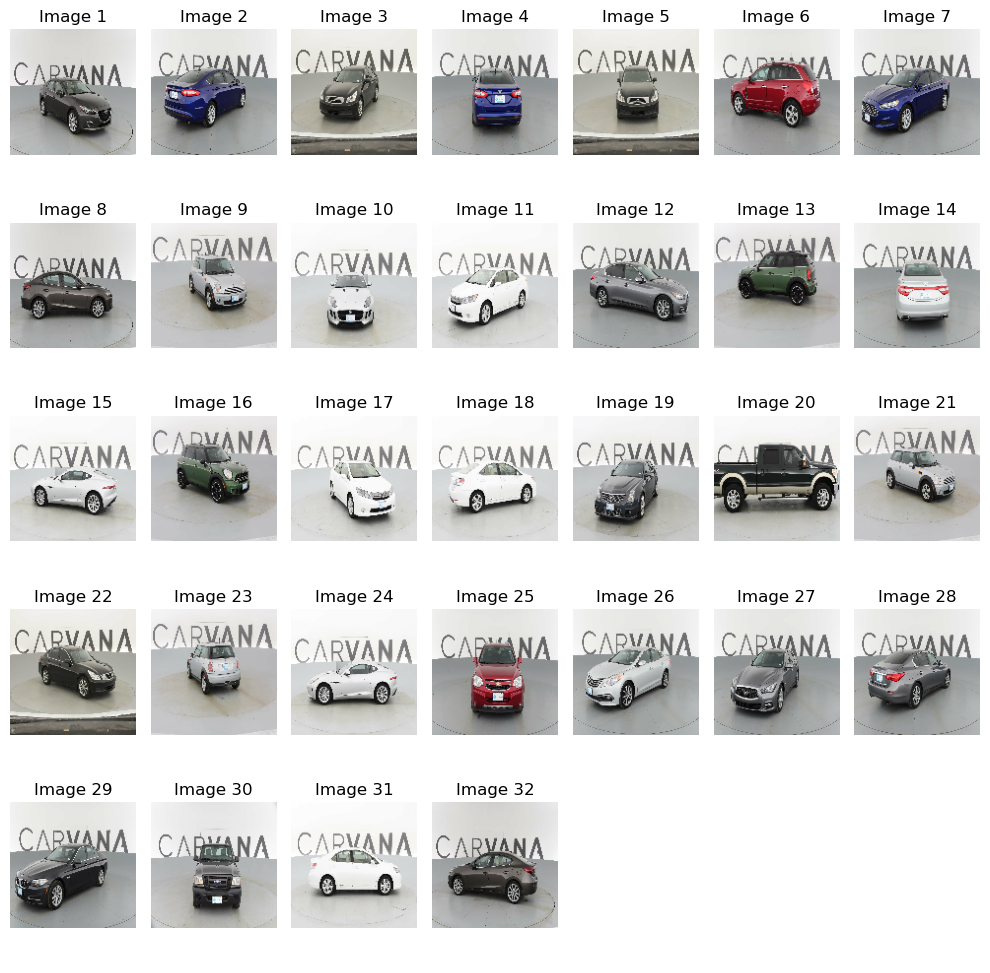

In [66]:
visualize_outputs(data=test_imgs, figsize=(10,10))

In [67]:
test_augment_funcs = build_augmenter(aug_functions, args.img_size)

In [68]:
out_aug_imgs = test_augment_funcs((test_imgs[0], test_imgs[1], tf.constant([0.05])))

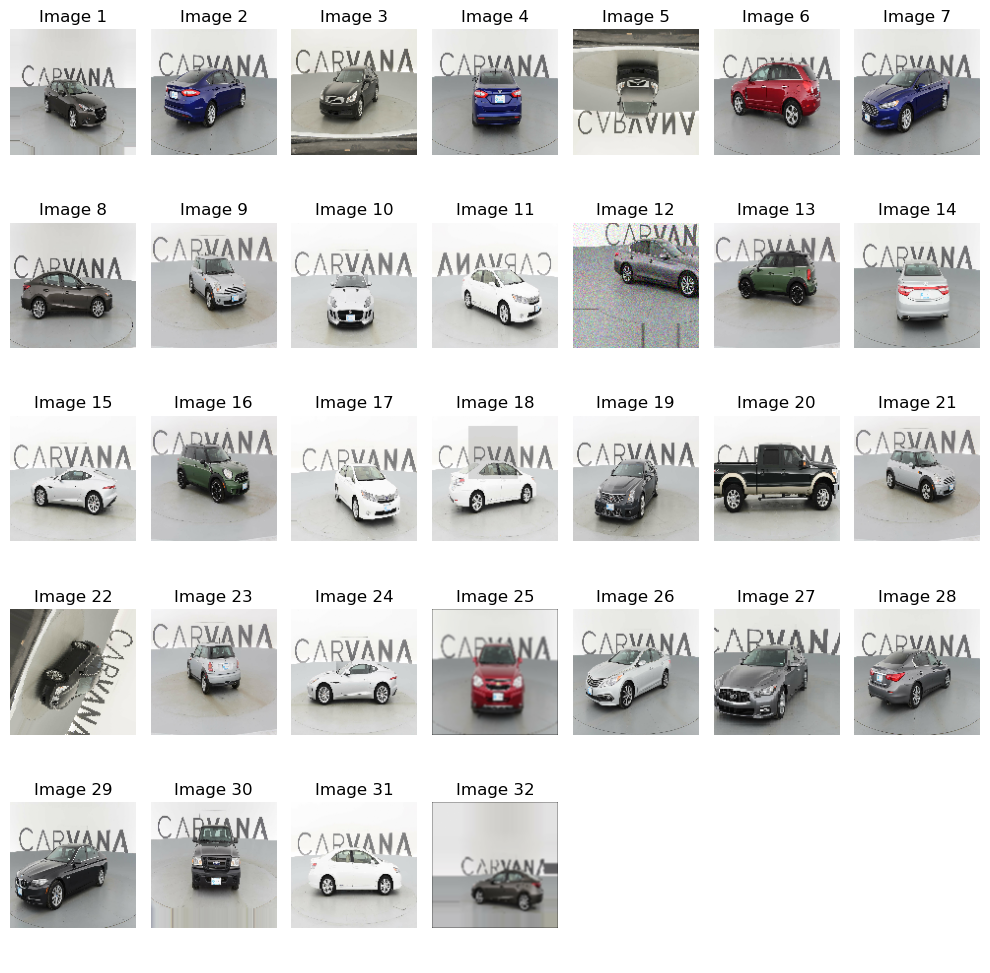

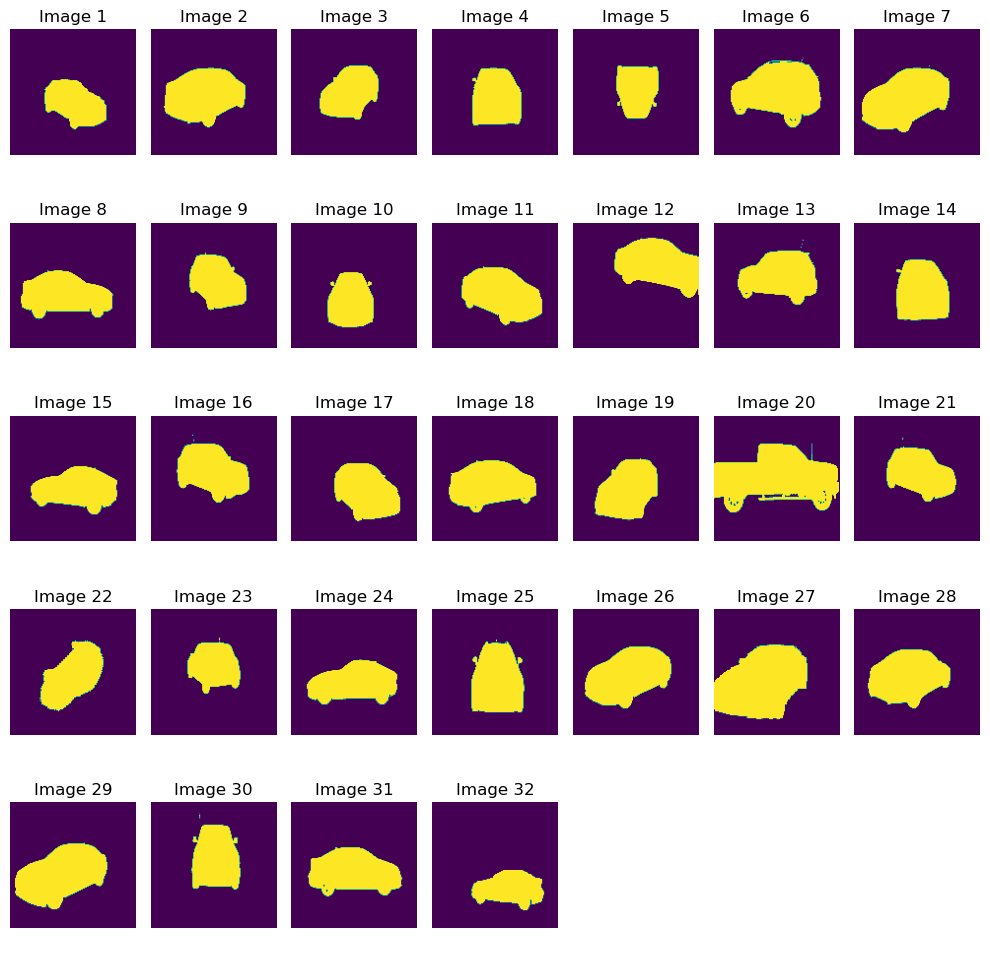

In [69]:
visualize_outputs(data=out_aug_imgs, figsize=(10,10))
visualize_outputs(data=[out_aug_imgs[1], out_aug_imgs[0]], figsize=(10,10))

In [70]:
test_ada = Ada(args.img_size, aug_functions=aug_functions, switch=True)

In [74]:
test_ada.update(tf.constant(0.2))
test_ada.probability

<tf.Variable 'ada_p:0' shape=(1, 1) dtype=float32, numpy=array([[0.639371]], dtype=float32)>

In [75]:
test_ada_out = test_ada(test_imgs, training=True)

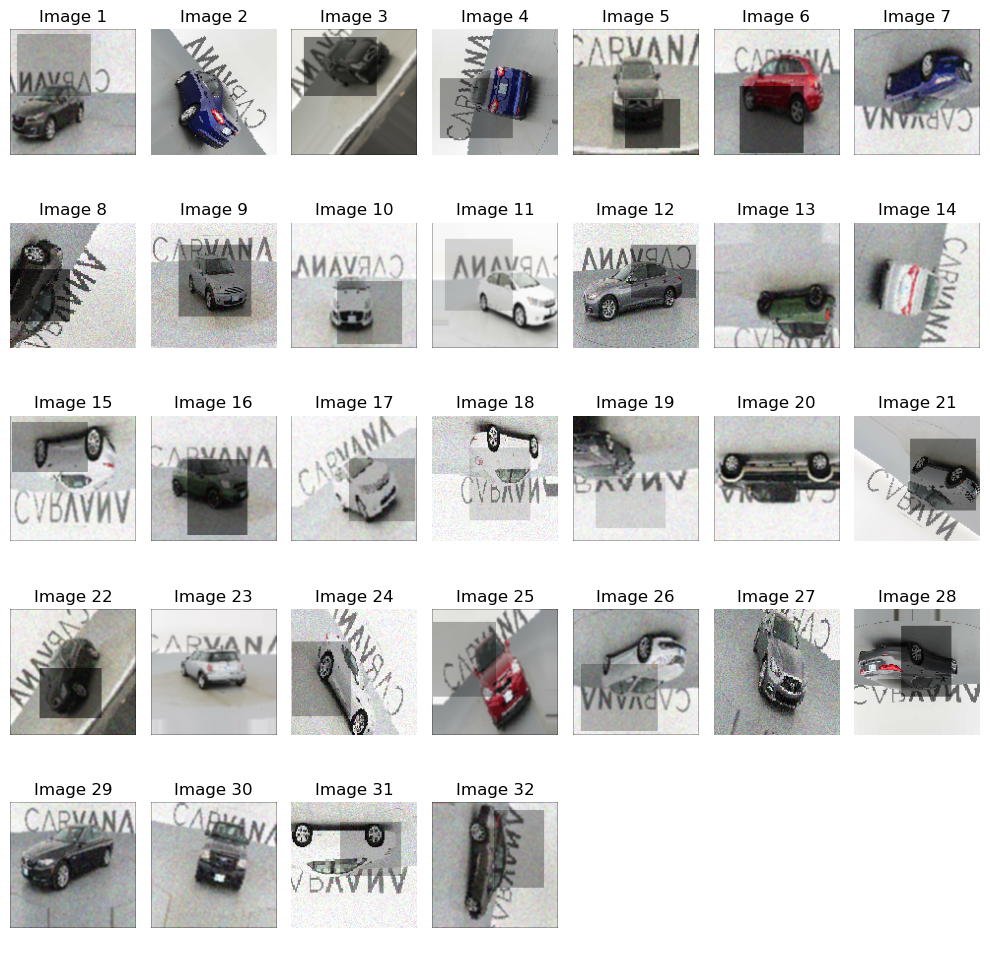

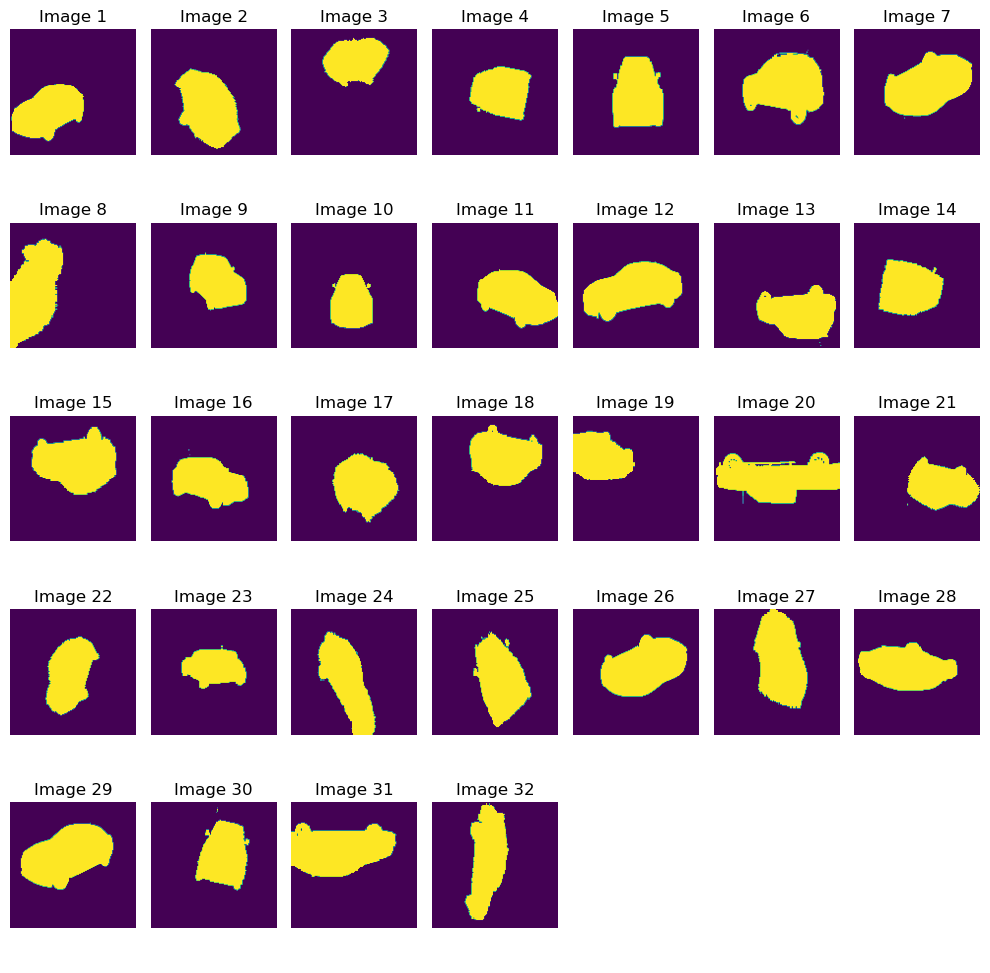

In [76]:
visualize_outputs(data=test_ada_out, figsize=(10,10))
visualize_outputs(data=[test_ada_out[1], test_ada_out[0]], figsize=(10,10))

# Train

In [53]:
save_filepath = r'D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\Instance Segmentation\saved_model\temp_model.h5'
callbacks_list = create_callbacks(save_filepath, args, temp_model)
if args.training_method == 'eagerly':
    callbacks = tf.keras.callbacks.CallbackList(callbacks_list, add_history=True, model=temp_model)

In [54]:
class FixedMean(tf.keras.metrics.Mean):
    def update_state(self, y_true, y_pred, sample_weight=None):
        super().update_state(y_pred, sample_weight=sample_weight)

In [55]:
@tf.function
def train_step(imgs, labels):

    imgs, labels = augment_func((imgs, labels), training=True)

    with tf.GradientTape() as tape:
        predicted = temp_model(imgs, training=True)
        loss_value = dice_loss(labels, predicted)
        
    grads = tape.gradient(loss_value, temp_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, temp_model.trainable_weights))

    augment_func.update(loss_value)
    loss_tracker.update_state(loss_value)
    dice_coeff_tracker.update_state(1-loss_value)
    augmentation_probability_tracker.update_state(augment_func.probability)
    return loss_value

@tf.function
def test_step(imgs, labels):

    val_predicted = temp_model(imgs, training=False)
    loss_value = dice_loss(labels, val_predicted)

    val_loss_tracker.update_state(loss_value)
    val_dice_coeff_tracker.update_state(1-loss_value)

  0%|          | 0/87 [00:00<?, ? Batches/s]

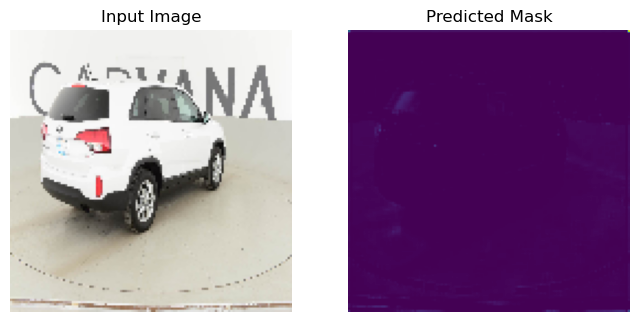

Epoch: 1: 100%|██████████| 87/87 [00:22<00:00,  3.84 Batches/s, augmentation_probability=0.0577, dice_coefficient=0.187, loss=0.813]



Epoch 1: loss_metric improved from inf to 0.8132078647613525, saving model to D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\Instance Segmentation\saved_model\temp_model.h5
Validation: Epoch - 0 val_dice_coeff - 0.18979200720787048 - val_loss - 0.8102080225944519


Epoch: 2: 100%|██████████| 87/87 [00:22<00:00,  3.90 Batches/s, augmentation_probability=0.0579, dice_coefficient=0.187, loss=0.813]



Epoch 2: loss_metric improved from 0.8132078647613525 to 0.8130963444709778, saving model to D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\Instance Segmentation\saved_model\temp_model.h5
Validation: Epoch - 1 val_dice_coeff - 0.18980462849140167 - val_loss - 0.8101953268051147


  0%|          | 0/87 [00:00<?, ? Batches/s]

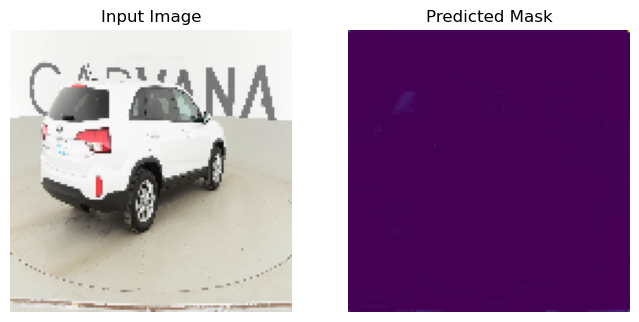

Epoch: 3: 100%|██████████| 87/87 [00:23<00:00,  3.66 Batches/s, augmentation_probability=0.0581, dice_coefficient=0.187, loss=0.813]



Epoch 3: loss_metric did not improve from 0.8130963444709778
Validation: Epoch - 2 val_dice_coeff - 0.18980805575847626 - val_loss - 0.810191810131073


In [56]:
if args.training_method == 'eagerly':

    img_path=r'D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\29bb3ece3180_11.jpg'
    test_img_for_epoch_viz = img_to_array(load_img(img_path, target_size=args.img_size)) / 255
    temp_model.compile(optimizer=optimizer, loss=dice_loss, metrics=[loss_tracker])

    # Callback on train begin
    callbacks.on_train_begin()

    # Training Loop
    for epoch in range(args.epochs):

        with tqdm(enumerate(ds_train), unit=' Batches', total=len(ds_train)) as tepoch:

            # Callback on epoch begin
            callbacks.on_epoch_begin(epoch)

            for batch, (images, labels) in tepoch:

                # Set description and get loss value
                tepoch.set_description(f"Epoch: {epoch+1}")
                loss_value = train_step(images, labels)        

                # Display results after each batch
                train_loss = loss_tracker.result()
                train_acc = dice_coeff_tracker.result()
                aug_p = augmentation_probability_tracker.result()
                tepoch.set_postfix(loss=train_loss.numpy(), dice_coefficient=train_acc.numpy(), augmentation_probability=aug_p.numpy())

            # Callback on epoch end
            logs = {args.monitor: train_loss}
            callbacks.on_epoch_end(epoch, logs)

        # Reset metrics at the end of each epoch
        dice_coeff_tracker.reset_states()
        loss_tracker.reset_states()
        
        for batch, (images, labels) in enumerate(ds_val):

            test_step(images, labels)

        # Display results after each epoch
        val_acc = val_dice_coeff_tracker.result()
        val_loss = val_loss_tracker.result()
        print("Validation: Epoch - {} val_dice_coeff - {} - val_loss - {}".format(epoch, val_acc, val_loss))
        
        # Reset metrics at the end of each epoch
        val_dice_coeff_tracker.reset_states()
        val_loss_tracker.reset_states()

    # Callback on train end
    callbacks.on_train_end()
else:

    temp_model.compile(optimizer=optimizer, loss=dice_loss, metrics=[loss_tracker]) # FixedMean()
    temp_model.fit(ds_train, epochs=args.epochs, callbacks=callbacks_list)

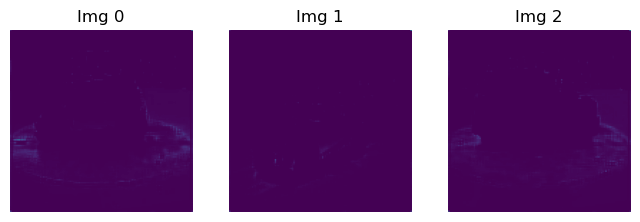

In [57]:
display_imgs(*temp_model(test_imgs[0], training=False)[0:3]) # test_imgs[0], training=True | test_imgs, training=True, augment=True

# TFRecords

In [76]:
from utils import save_images_to_tfrecord, read_tfrecord

In [77]:
output_file = r"D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\TFRecordFiles\train.tfrecord"
train_path = r'D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\train\train'
mask_path = r'D:\DL-CV-ML Projects\Carvana Challenge - Instance Segmentation\train_masks\train_masks'
# save_images_to_tfrecord(train_path, mask_path, output_file)

In [78]:
tfrecord_file = 'D:\\DL-CV-ML Projects\\Carvana Challenge - Instance Segmentation\\TFRecordFiles\\train.tfrecord'
features = read_tfrecord(tfrecord_file)

In [79]:
features

{'image/encoded': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'image/width': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'image/height': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'image/filename': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'mask/encoded': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
 'mask/width': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'mask/height': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'mask/filename': FixedLenFeature(shape=[], dtype=tf.string, default_value=None)}

# Extra

In [ ]:
    # patience = 5
    # wait = 0
    # best = float('inf')
    # min_delta = 0.01
    
        # # Early stopping criteria
        # wait += 1
        # if val_loss < best - min_delta:
        #     best = val_loss
        #     wait = 0
        # if wait >= patience:
        #     break

In [ ]:
# def custom_data_augmentation_func(translate = 0.2,
#                                   rot = 0.5,
#                                   scale = 0.25,
#                                   p = 0.5,
#                                   img_size = (128, 128),
#                                   kernel_size = 3,
#                                   sigma = 1,
#                                   min_height = 50,
#                                   min_width = 50,
#                                   max_height = 80,
#                                   max_width = 80):

#     if len(img_size) == 2:
#         img_shape = img_size + (3,)
#         mask_shape = img_size + (1,)
    
#     if len(img_size) == 3:
#         img_shape = img_size
#         mask_shape = (img_size[0], img_size[1], 1)

#     input_img = layers.Input(shape=img_shape) # (H, W, C)
#     input_mask = layers.Input(shape=mask_shape) # (H, W, C)
#     x = (input_img, input_mask)
#     x = RandomHorizontalFlip(probability=p)(x)
#     x = RandomShift(translate=translate, probability=p)(x)
#     x = RandomRotate(probability=p, rot=rot)(x)
#     x = RandomZoom(probability=p, height_factor=scale, width_factor=scale)(x)
#     x = RandomMirror(probability=p)(x)
#     x = AddNoise(probability=p)(x)
#     x = GaussianBlur(kernel_size=kernel_size, sigma=sigma, probability=p)(x)
#     x = OverlayBox(probability=p, min_height=min_height, min_width=min_width, height=max_height, width=max_width)(x)
#     augmenter = tf.keras.Model([input_img, input_mask], x, name='custom_data_augmentation_function')

#     return augmenter


# class GenerateRandom(layers.Layer):
   
#     def __init__(self, **kwargs):
      
#       super(GenerateRandom, self).__init__(**kwargs)
      
#     def call(self, inputs): # (1, 1) e.g. [[8]]
       
#        inputs = tf.cast(inputs, tf.int32)
#        rand = tf.random.uniform(shape=(inputs[0]), minval=0., maxval=1., dtype=tf.float32)
#        return rand


# def step(values): # "hard sigmoid", useful for binary accuracy calculation from logits. negative values -> 0.0, positive values -> 1.0  
#     return 0.5 * (1.0 + tf.sign(values))

# class DoNothing(tf.keras.Model):

#     def __init__(self, **kwargs):

#         super(DoNothing, self).__init__(**kwargs)
#         self.probability = tf.Variable(0.0, trainable=False)

#     def update(self, loss):
#         self.probability.assign(loss)

#     def call(self, inputs, training=False):
#         return inputs

# class Ada(tf.keras.Model):

#     def __init__(self, 
#                  img_size=(128, 128),
#                  translate=0.2, 
#                  rot=0.5, 
#                  scale=0.25, 
#                  p=0.5,
#                  batch_p=0.0,
#                  kernel_size=3,
#                  sigma=1,
#                  min_height=50, 
#                  min_width=50, 
#                  max_height=80, 
#                  max_width=80,
#                  **kwargs):
        
#         super(Ada, self).__init__(**kwargs)
        
#         self.probability = tf.Variable(batch_p, trainable=False)
#         self.target_accuracy = 0.85 # 0.85, 0.95
#         self.integration_steps = 500 # 1000, 1500, 2000

#         self.augmenter = build_augmenter(aug_functions, img_size)
#         self.augmenter = custom_data_augmentation_func(translate=translate, rot=rot, scale=scale, p=p, img_size=img_size, kernel_size=kernel_size, 
#                                                        sigma=sigma, min_height=min_height, min_width=min_width, max_height=max_height, max_width=max_width)
    
#     def call(self, inputs, training=False):

#         # imgs, masks = inputs # [bs, H, W, C], [bs, H, W, C]

#         if training:
          
#           batch_size = tf.shape(imgs)[0]
#           augmented_imgs, augmented_masks = self.augmenter(inputs, training) # (2, bs, H, W, C)
#           augmentation_values = tf.random.uniform(shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0) # Generate random numbers
#           augmentation_bools = tf.math.less(augmentation_values, self.probability) # Get booleans in the indices where we want augmented images or not
#           imgs = tf.where(augmentation_bools, augmented_imgs, imgs)
#           masks = tf.where(augmentation_bools, augmented_masks, masks)

#         return inputs

#     def update(self, loss):

#         # The more accurate the model, the more augmentations is performed.
#         accuracy_error = (1. - loss) - self.target_accuracy
#         self.probability.assign( tf.clip_by_value(self.probability + accuracy_error / self.integration_steps, 0.0, 1.0) )

In [ ]:
       # if args.augment_in_ds == True:
        #     self.ada = DoNothing()
        # else:
        #     self.ada = Ada(p=ada_p, batch_p=ada_batch_p)


        # if augment: augmented_images, augmented_masks = self.ada(inputs, training=training)
        # else: augmented_images, augmented_masks = inputs


# Inputs: imgs: tf.float32 [0, 1], masks: tf.int32 [0, 255]
# Augmentation: input: tf.float32 [0, 1], tf.int32 [0, 255]; output: tf.float32 [0, 1], tf.int32 [0, 255]
# Model: input: tf.float32 [0, 1]; output: tf.float32 [0, 1] <--------- output should be tf.int32 [0, 255] but its ok
# Loss: input: y_true: tf.int32 [0, 255], y_pred: tf.float32 [0, 1]

In [ ]:
    #   if optimizer is None:
    #         self.optimizer = tf.keras.optimizers.Adam(**{"learning_rate": 1e-3, "beta_1": 0.5, "beta_2": 0.99, "epsilon": 1e-8})
    #     elif isinstance(optimizer, str):
    #         self.optimizer = tf.keras.optimizers.get(optimizer)
    #     else: self.optimizer = optimizer

    #     if metrics == []:
    #         self.loss_tracker = tf.keras.metrics.Mean(name="loss_metric")  
    #     elif isinstance(metrics, str):
    #         self.loss_tracker = tf.keras.metrics.get(metrics) 
    #     else: self.loss_tracker = metrics     

In [ ]:
            # if len(img_size) == 2:
            #     img_shape = img_size + (3,)
            #     mask_shape = img_size + (1,)
            
            # if len(img_size) == 3:
            #     img_shape = img_size
            #     mask_shape = (img_size[0], img_size[1], 1)

            # input_img = layers.Input(shape=img_shape)
            # input_mask = layers.Input(shape=mask_shape)
            # x = (input_img, input_mask)
            # x = augment_func(x)
            # x = my_model(x)
            # model_with_augmentation = tf.keras.Model([input_img, input_mask], x, name='model_with_augmentation')
            
            # return None, model_with_augmentation